In [16]:
import skxray.core.speckle as speckle
import skxray.core.roi as roi
import skxray.core.utils as utils

import xray_vision.mpl_plotting as mpl_plot
import xray_vision.mpl_plotting.speckle as speckle_plot

import numpy as np
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

# Easily switch between interactive and static matplotlib plots
interactive_mode = True

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

#backend = mpl.get_backend()
cmap = "Dark2"

## Data Directory

In [2]:
data_dir = "/Volumes/Data/BeamLines/CSX_Data/X_data/"

X_data = np.load(data_dir+"TbCO_speckle_visibility.npy")
X_data.shape

(230, 230)

### mask 

<IPython.core.display.Javascript object>


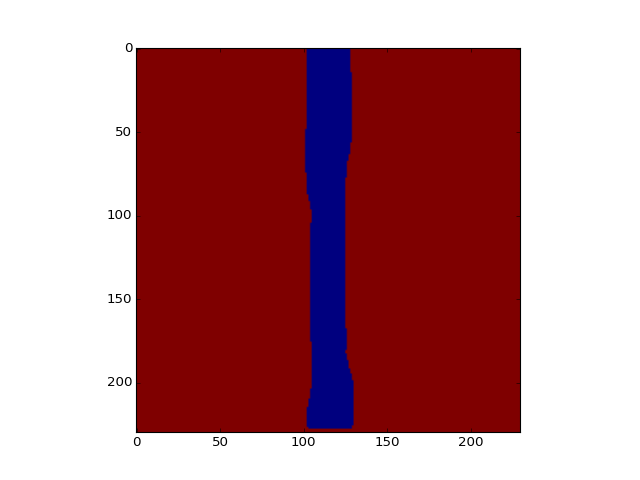

In [4]:
mask = ~np.load(data_dir+"Tbco_mask.npy")
plt.figure()
plt.imshow(mask)
plt.show()

<IPython.core.display.Javascript object>


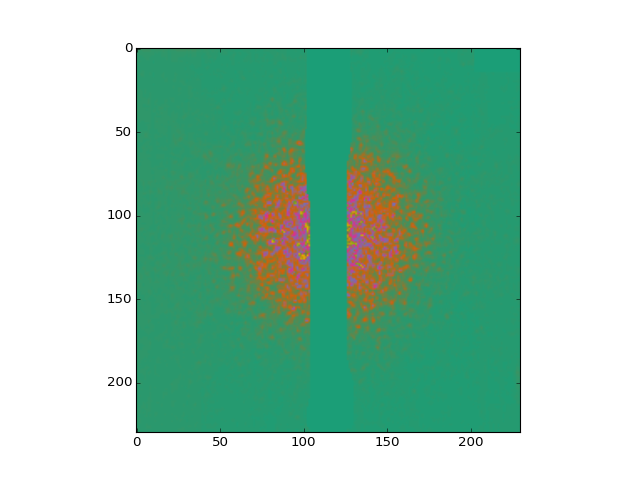

In [5]:
plt.figure()
plt.imshow(X_data*mask, cmap=cmap)
plt.show()

In [6]:
inner_radius = 20
width = 1
spacing = 2
num_rings = 3

#  create edges of the rings using roi.ring_edges
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 20.,  21.],
       [ 23.,  24.],
       [ 26.,  27.]])

<IPython.core.display.Javascript object>


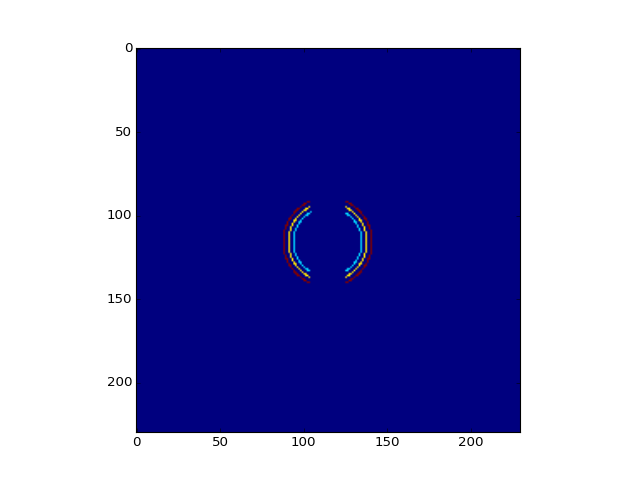

In [7]:
center = (116, 114)
rings = roi.rings(edges, center, X_data.shape)

rings_mask = rings*mask

plt.figure()
plt.imshow(rings_mask)
plt.show()


<IPython.core.display.Javascript object>


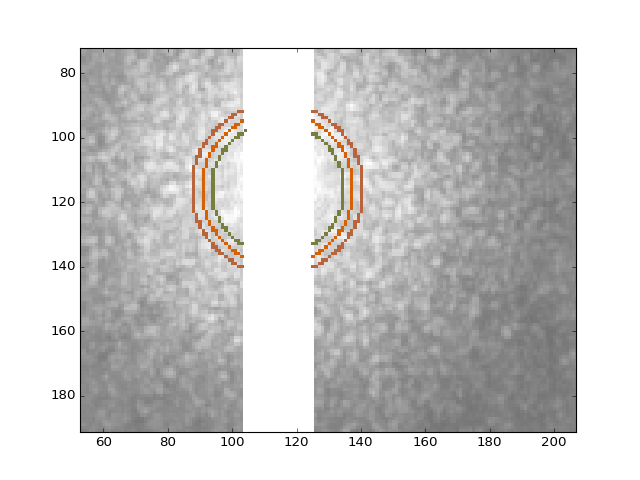

In [8]:
fig, ax = plt.subplots()
im, im_lbel = mpl_plot.roi.show_label_array_on_image(ax, X_data, rings_mask, cmap='Dark2')
plt.show()

#  get the max_cts or brightest pixel in the image

In [9]:
# this is before dividing by 36
max_cts = roi.roi_max_counts(X_data, rings_mask)
max_cts

6639.0165426329177

In [10]:
max_cts = roi.roi_max_counts(X_data/36, rings_mask)
max_cts

184.41712618424771

In [19]:
roi_pix, index = roi.roi_pixel_values(X_data/36, rings_mask, index=None)

In [116]:
mean_int_ring, index = roi.mean_intensity(X_data1, rings_mask, index=None)
mean_int_ring

array([[ 54.07472368,  49.98114166,  44.04222815]])

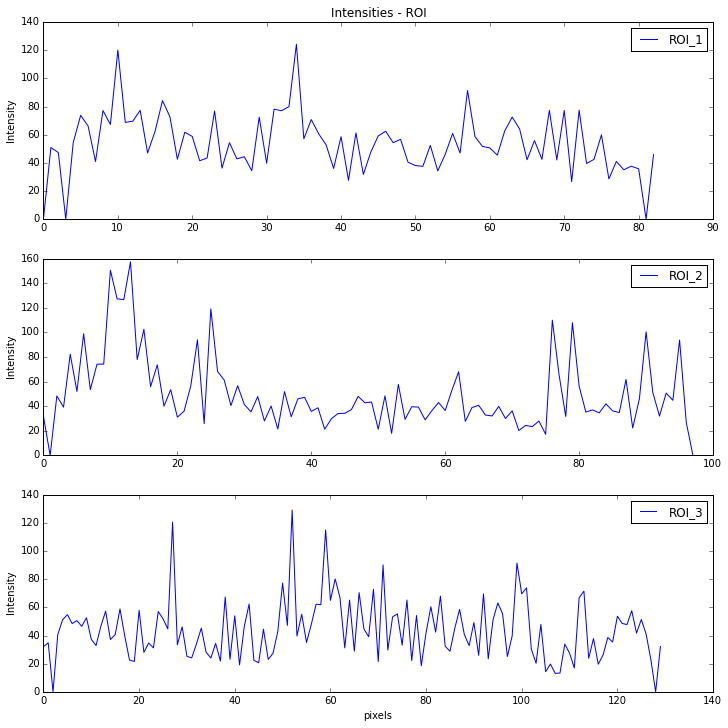

In [22]:
fig, ax = plt.subplots(3, figsize=(12, 12))
speckle_plot.rois_as_lines(ax, roi_pix)
plt.show()

In [57]:
X_data1 = (X_data/36).reshape(1, 230, 230)

In [58]:
p_k, std_dev = speckle.xsvs((X_data1, ), rings_mask, timebin_num=2,
                             number_of_img=3, max_cts=160)

In [59]:
p_k.shape

(2, 3)

In [103]:
num_times = 2
num_rois = num_rings
norm_bin_edges, norm_bin_centers = speckle.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts=160)

#  Plots for the first time step?, for 3 ROI's

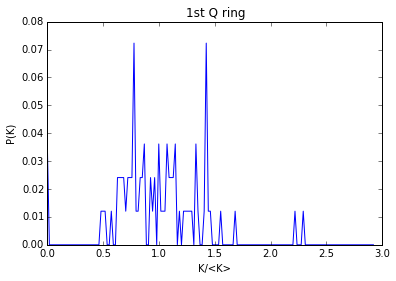

In [113]:
plt.figure()
plt.plot(norm_bin_edges[0, 0][:-1],p_k[0, 0])
plt.title("1st Q ring")
plt.xlabel("K/<K>")
plt.ylabel("P(K)")
plt.show()

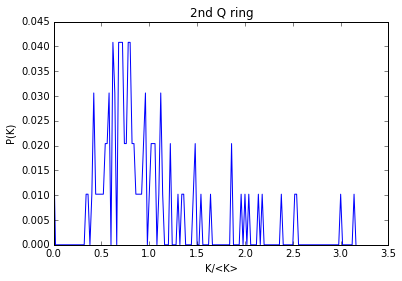

In [114]:
plt.figure()
plt.plot(norm_bin_edges[0, 1][:-1], p_k[0, 1])
plt.title("2nd Q ring")
plt.xlabel("K/<K>")
plt.ylabel("P(K)")
plt.show()

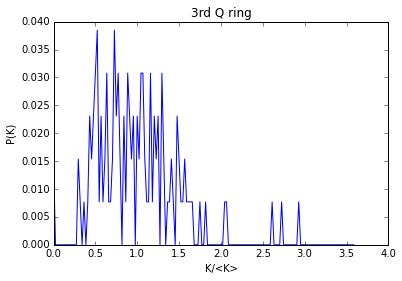

In [115]:
plt.figure()
plt.plot(norm_bin_edges[0, 2][:-1], p_k[0, 2])
plt.title("3rd Q ring")
plt.xlabel("K/<K>")
plt.ylabel("P(K)")
plt.show()

In [108]:
time_steps = [1, 2]

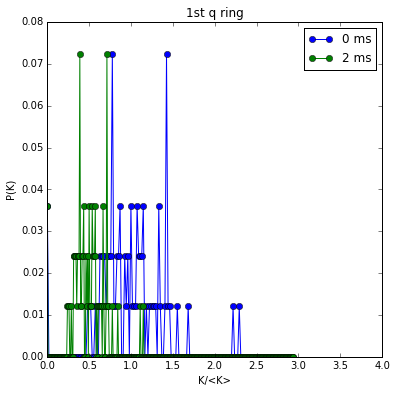

In [109]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(2):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], p_k[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring ")
plt.show()

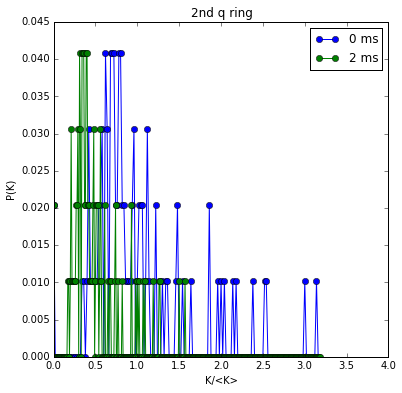

In [111]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(2):
    art, = axes.plot(norm_bin_edges[i, 1][:-1], p_k[i, 1], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("2nd q ring ")
plt.show()

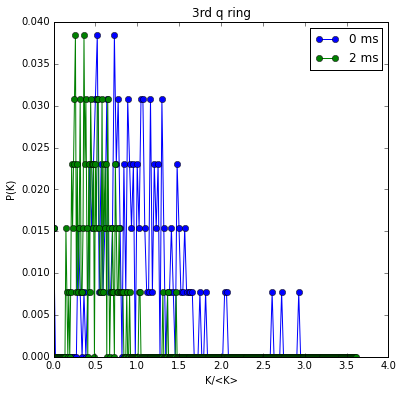

In [112]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(2):
    art, = axes.plot(norm_bin_edges[i, 2][:-1], p_k[i, 2], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("3rd q ring ")
plt.show()

In [67]:
import time
import logging
logger = logging.getLogger(__name__)

def xsvs_c(image_sets, label_array, number_of_img, timebin_num=2,
         max_cts=None):
    """
    This function will provide the probability density of detecting photons
    for different integration times.

    The experimental probability density P(K) of detecting photons K is
    obtained by histogramming the speckle counts over an ensemble of
    equivalent pixels and over a number of speckle patterns recorded
    with the same integration time T under the same condition.

    Parameters
    ----------
    image_sets : array
        sets of images
    label_array : array
        labeled array; 0 is background.
        Each ROI is represented by a distinct label (i.e., integer).
    number_of_img : int
        number of images (how far to go with integration times when finding
        the time_bin, using skxray.utils.geometric function)
    timebin_num : int, optional
        integration time; default is 2
    max_cts : int, optional
       the brightest pixel in any ROI in any image in the image set.
       defaults to using skxray.core.roi.roi_max_counts to determine
       the brightest pixel in any of the ROIs

    Returns
    -------
    prob_k_all : array
        probability density of detecting photons
    prob_k_std_dev : array
        standard deviation of probability density of detecting photons

    Notes
    -----
    These implementation is based on following references
    References: text [1]_, text [2]_

    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    .. [2] R. Bandyopadhyay, A. S. Gittings, S. S. Suh, P.K. Dixon and
       D.J. Durian "Speckle-visibilty Spectroscopy: A tool to study
       time-varying dynamics" Rev. Sci. Instrum. vol 76, p  093110, 2005.

    There is an example in https://github.com/scikit-xray/scikit-xray-examples
    It will demonstrate the use of these functions in this module for
    experimental data.

    """
    if max_cts is None:
        max_cts = roi.roi_max_counts(image_sets, label_array)

    # find the label's and pixel indices for ROI's
    labels, indices = roi.extract_label_indices(label_array)

    # number of ROI's
    u_labels = list(np.unique(labels))
    num_roi = len(u_labels)

    # create integration times
    time_bin = utils.geometric_series(timebin_num, number_of_img)

    # number of times in the time bin
    num_times = len(time_bin)

    # number of pixels per ROI
    num_pixels = np.bincount(labels, minlength=(num_roi+1))[1:]

    # probability density of detecting photons
    prob_k_all = np.zeros([num_times, num_roi], dtype=np.object)

    # square of probability density of detecting photons
    prob_k_pow_all = np.zeros_like(prob_k_all)

    # standard deviation of probability density of detecting photons
    prob_k_std_dev = np.zeros_like(prob_k_all)

    # get the bin edges for each time bin for each ROI
    bin_edges = np.zeros(prob_k_all.shape[0], dtype=prob_k_all.dtype)
    for i in range(num_times):
        bin_edges[i] = np.arange(max_cts*2**i)

    start_time = time.time()  # used to log the computation time (optionally)

    for i, images in enumerate(image_sets):
        # Ring buffer, a buffer with periodic boundary conditions.
        # Images must be keep for up to maximum delay in buf.
        buf = np.zeros([num_times, timebin_num],
                       dtype=np.object)  # matrix of buffers

        # to track processing each time level
        track_level = np.zeros(num_times)

        # to increment buffer
        cur = np.full(num_times, timebin_num)

        # to track how many images processed in each level
        img_per_level = np.zeros(num_times, dtype=np.int64)

        prob_k = np.zeros_like(prob_k_all)
        prob_k_pow = np.zeros_like(prob_k_all)

        for n, img in enumerate(images):
            cur[0] = (1 + cur[0]) % timebin_num
            # read each frame
            # Put the image into the ring buffer.
            buf[0, cur[0] - 1] = (np.ravel(img))[indices]

            _process(num_roi, 0, cur[0] - 1, buf, img_per_level, labels,
                     max_cts, bin_edges[0], prob_k, prob_k_pow)

            # check whether the number of levels is one, otherwise
            # continue processing the next level
            level = 1

            while level < num_times:
                if not track_level[level]:
                    track_level[level] = 1
                else:
                    prev = 1 + (cur[level - 1] - 2) % timebin_num
                    cur[level] = 1 + cur[level] % timebin_num

                    buf[level, cur[level]-1] = (buf[level-1,
                                                    prev-1] +
                                                buf[level-1,
                                                    cur[level - 1] - 1])
                    track_level[level] = 0

                    _process(num_roi, level, cur[level]-1, buf, img_per_level,
                             labels, max_cts, bin_edges[level], prob_k,
                             prob_k_pow)
                    level += 1

            prob_k_all += (prob_k - prob_k_all)/(i + 1)
            prob_k_pow_all += (prob_k_pow - prob_k_pow_all)/(i + 1)

    prob_k_std_dev = np.power((prob_k_pow_all -
                               np.power(prob_k_all, 2)), .5)

    logger.info("Processing time for XSVS took %s seconds."
                "", (time.time() - start_time))
    return prob_k_all, prob_k_std_dev


def _process(num_roi, level, buf_no, buf, img_per_level, labels,
             max_cts, bin_edges, prob_k, prob_k_pow):
    """
    Internal helper function. This modifies inputs in place.

    This helper function calculate probability of detecting photons for
    each integration time.

    .. warning :: This function mutates the input values.

    Parameters
    ----------
    num_roi : int
        number of ROI's
    level : int
        current time level(integration time)
    buf_no : int
        current buffer number
    buf : array
        image data array to use for XSVS
    img_per_level : int
        to track how many images processed in each level
    labels : array
        labels of the required region of interests(ROI's)
    max_cts: int
        maximum pixel count
    bin_edges : array
        bin edges for each integration times and each ROI
    prob_k : array
        probability density of detecting photons
    prob_k_pow : array
        squares of probability density of detecting photons
    """
    img_per_level[level] += 1
    u_labels = list(np.unique(labels))

    for j, label in enumerate(u_labels):
        roi_data = buf[level, buf_no][labels == label]
        print "roi_data", roi_data
        spe_hist, bin_edges = np.histogram(roi_data, bins=bin_edges,
                                           density=True)
        spe_hist = np.nan_to_num(spe_hist)
        print "spe_hist", spe_hist
        prob_k[level, j] += (spe_hist -
                             prob_k[level, j])/(img_per_level[level])
        print "prob_k",prob_k

        prob_k_pow[level, j] += (np.power(spe_hist, 2) -
                                 prob_k_pow[level, j])/(img_per_level[level])

In [68]:
p_k_c, std_dev_c = xsvs_c((X_data1, ), rings_mask, timebin_num=2,
                             number_of_img=3, max_cts=160)

roi_data [   0.           50.89658426   47.3485032     0.           54.36447322
   73.79384836   66.20974783   40.98621456   77.19200142   67.25887711
  120.17904841   68.7409849    69.62090197   77.33186552   47.05148384
   62.4380418    84.24636554   72.74841948   42.61902241   61.77339335
   58.80043806   41.51093986   43.46326562   76.88737335   36.25934404
   54.32886818   42.84579788   44.35108738   34.42435217   72.50788548
   39.7864504    78.17090244   77.06233693   79.98296644  124.34852432
   57.13729676   70.77374643   60.59166065   52.7214875    36.02963893
   58.59583612   27.59610936   61.30113776   31.77496372   47.69739048
   59.20430523   62.47590124   54.36502044   56.73412971   40.47774021
   38.06748167   37.56403662   52.42270143   34.32767039   46.06257537
   60.9496907    46.99667988   91.48325045   58.69215483   51.74963215
   50.62035425   45.47189233   62.6979323    72.58610543   64.10922585
   42.22585654   55.87051661   42.53427489   77.33867176   42.058538